In [1]:
# project: p11
# submitter: zlweinstein
# partner: none
# hours: 6

In [2]:
import os
import csv
import json
import pandas 
import matplotlib
from collections import namedtuple 
from datetime import datetime as dt #this is for a time_delta only
from questions import view_plot_data, verify_bar, verify_scatter
import copy

In [3]:
%matplotlib inline

In [4]:
def read_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)
    
#opens a file that we're calling path 
    
def get_mapping(pathname):
    try:
        return read_json(pathname)
    except(json.JSONDecodeError):
        empty_dict = {}
        return empty_dict
    
    
#opening a file called path and if it's not a json file them it's returning an empty dict, otherwise it's opening a file called pathname


Comment = namedtuple("Comment", ["video_id", "comment_length", "author_id", "likes", "published_at"])
#creating a namedtuple that has certain characteristics


def get_comment_data(comment_file):
    csv_data = process_csv(comment_file)
    header = csv_data[0]
    comment_rows = csv_data[1:]
#opening up a CSV file, assigning header to the header, and the data to comment_rows
    
    comment_id_idx = header.index("comment_id")
    video_id_idx = header.index("video_id")
    comment_length_idx = header.index("comment_length")
    author_id_idx = header.index("author_id")
    likes_idx = header.index("likes")
    published_at_idx = header.index("published_at")
    
    comment_dict = {}
    for row in comment_rows:
#         if row == "" or len(row) != len(header):
#             continue
#         try:
#             r = Comment(row[video_id_idx], int(row[comment_length_idx]), row[author_id_idx], int(row[likes_idx]), row[published_at_idx])
#         except:
#             continue
#         comment_dict[row[comment_id_idx]] = r
        if "" not in row: 
            try :
                comment_data = Comment(row[video_id_idx], int(row[comment_length_idx]), row[author_id_idx], int(row[likes_idx]), row[published_at_idx])
                comment_dict[row[comment_id_idx]] = comment_data
            except (IndexError, ValueError) :
                continue 
    return comment_dict

#using a try except to fill in the named tuple with the certain characteristics


def bucketize(attribute, videos):
    bucket_dict = {}
    for video in videos:
        attributes = videos[video][attribute]
        if type(attributes) == list:
            for item in attributes:
                if item not in bucket_dict:
                    bucket_dict[item] = []
                if item in bucket_dict:
                    bucket_dict[item].append(video)
        else:
            if attributes not in bucket_dict:
                bucket_dict[attributes] = []
            if attributes in bucket_dict:
                bucket_dict[attributes].append(video)
    return bucket_dict

#creates an empty dict, for all the IDs in videos it assigns the varable attributes to whatever the user inputs as attribute
#if the attribute is a list then turns it into a dictionary with each item in the list as the key and the value as the video
#if the item is not a list then it just adds the item as the key and the video as the value 


def plot_dict(d, label="Please Label Me!!!"):
    ax = pandas.Series(d).sort_index().plot.bar(color="black", fontsize=16)
    ax.set_ylabel(label, fontsize=16)
    
def process_csv(filename):
    exampleFile = open(filename, encoding="utf-8")  
    exampleReader = csv.reader(exampleFile) 
    exampleData = list(exampleReader)        
    exampleFile.close()  
    return exampleData

## From lab-p10
def list_files_in(pathname):
    list_at_location = []
    for files in os.listdir(pathname):
        if not files.startswith("."):
            list_at_location.append(files)
    return sorted(list_at_location)
   

def list_paths_in(pathname):
    list_at_location = []
    for files in os.listdir(pathname):
        if not files.startswith("."):
            pname_dir = os.path.join("data", files)
            list_at_location.append(pname_dir)
    return sorted(list_at_location)

all_paths = list_paths_in("data")

comment_paths = []
for files in all_paths:
    if "comment_data" in files:
        comment_paths.append(files)
        
channel_paths = []
for files in all_paths:
    if "channel_ids" in files:
        channel_paths.append(files)

channel_dict = {}
for path in channel_paths:
    current_path = get_mapping(path)
    for channel in current_path:
        channel_dict[channel] = current_path[channel]
        
comments = {}
for file in comment_paths:
    comments.update(get_comment_data(file))


## From p10 (Q12)
## Code to populate `comment_buckets` 
comment_buckets = {}
for i in comments:
    video_id = comments[i].video_id
    if video_id not in comment_buckets:
        comment_buckets[video_id] = []
    if video_id in comment_buckets:
        comment_buckets[video_id].append(i)


## From p10
def get_videos(data_file, video_mapping_file):
    data = process_csv(data_file)
    header = data[0]
    all_videos = data[1:]
    video_mapping = get_mapping(video_mapping_file)
    videos_dict = dict()
 
    for video in all_videos:
        new_dict = {}
        
        try:
            video_id = video[header.index('video_id')]
            title = read_json(video_mapping_file)[video_id]            
        except:
            continue
            
        new_dict['title'] = title
        for row in header[1:]:
            try:
                if row == "likes" or row == "dislikes":
                    if video[header.index("likes")] == "" or video[header.index("dislikes")] == "":
                        new_dict['ratings_enabled'] = False
                        new_dict['likes'] = None
                        new_dict['dislikes'] = None
                    else:
                        new_dict['ratings_enabled'] = True
                        new_dict['likes'] = int(video[header.index("likes")])
                        new_dict['dislikes'] = int(video[header.index("dislikes")])
                elif row == "views":
                    new_dict[row] = int(video[header.index("views")])
                elif row == "tags":
                    new_dict[row] = (video[header.index(row)]).split("|")
                elif row == "channel_id":
                    new_dict['channel_name'] = channel_dict[video[header.index('channel_id')]]
                else:
                    new_dict['comments'] = comment_buckets[video[header.index('video_id')]]
                    new_dict[row] = video[header.index(row)]
            except:
                continue
                
        videos_dict[video_id] = new_dict

    return videos_dict

videos = get_videos(os.path.join('data','video_data.csv'), os.path.join('data','video_ids.json'))
videos_copy = copy.deepcopy(videos)
    
def plot_dict(d, label="Please Label Me!!!"):
    ax = pandas.Series(d).sort_index().plot.bar(color="black", fontsize=16)
    ax.set_ylabel(label, fontsize=16)
    
def scatter(x, y, xlabel="please label me!", ylabel="please label me!"):
    df = pandas.DataFrame({"x":x, "y":y})
    ax = df.plot.scatter(x="x", y="y", color="black", fontsize=16, ylim=0)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)


In [5]:
def process_duration(duration_str):

    duration = int(duration_str[0:2]) * 3600 + int(duration_str[3:5]) * 60 + int(duration_str[6:8])
    value = (duration // 300) * 5

    return value

print(process_duration('00:04:12'))
print(process_duration('00:28:21'))

0
25


In [6]:
from questions import view_plot_data, verify_bar, verify_scatter

In [7]:
videos_copy = copy.deepcopy(videos)
#videos_copy

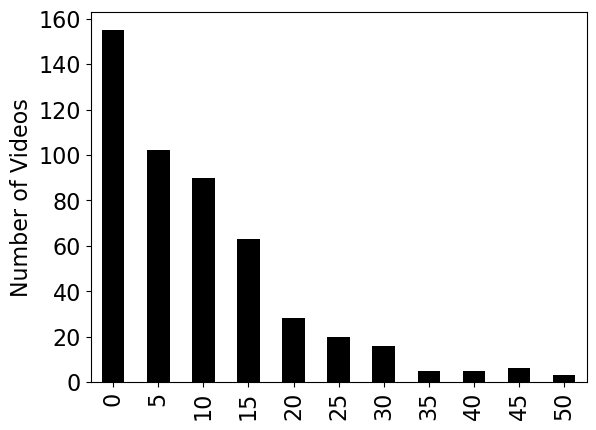

In [8]:
#Q1: Plot the distribution of video durations as a histogram.
for video in videos_copy:
    current_time = videos_copy[video]["duration"]
    new_duration = process_duration(current_time)
    videos_copy[video]["duration"] = new_duration
duration_buckets = bucketize("duration", videos_copy)

new_dict = {}
for keys in duration_buckets:
    new_dict[keys] = len(duration_buckets[keys])

new_dict
plot_dict(new_dict, label="Number of Videos")

In [9]:
#q1.1
verify_bar(new_dict, 1)

True

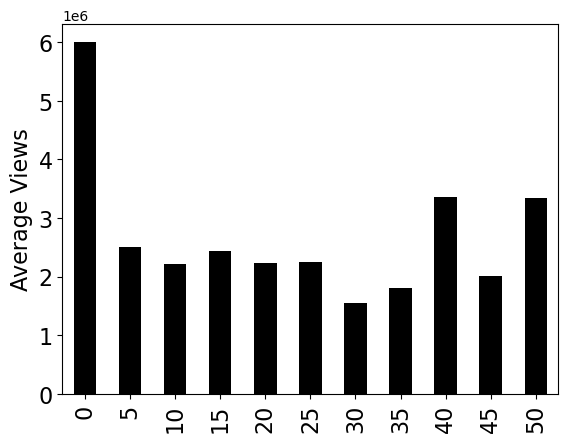

In [10]:
#Q2: Plot the correlation between duration of video (x-axis) and average views (y-axis) as a histogram.

avg_views_dict = {}
videos_copy
for keys in duration_buckets:
    views_list = []
    for ids in duration_buckets[keys]:
        views_list.append(videos_copy[ids]["views"])
    avg = sum(views_list) / len(views_list)

    avg_views_dict[keys] = avg
avg_views_dict


plot_dict(avg_views_dict, label="Average Views")

In [11]:
#q2.1
verify_bar(avg_views_dict, 2)

True

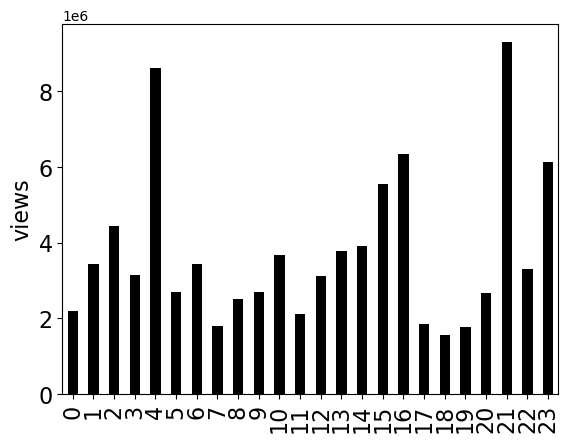

In [12]:
#Q3: Plot the correlation between the hour at which the video is published (x-axis) and the average number of views (y-axis) across all videos in that hour as a histogram.
videos_copy

time_views_dict = {} #key time cdt value list of views

for video_ids in videos_copy:
    utc_hour = int(videos_copy[video_ids]["published_at"][11:13])
    cdt_hour = (utc_hour-5)%24
    if cdt_hour not in time_views_dict:
        time_views_dict[cdt_hour] = []
    if cdt_hour in time_views_dict:
        time_views_dict[cdt_hour].append(videos_copy[video_ids]["views"])

time_views_dict[cdt_hour]

time_views_dict = {time:sum(views_list)/len(views_list) for time, views_list in time_views_dict.items()}
plot_dict(time_views_dict, label="views")


In [13]:
#Q3.1 Verify your plot using verify_bar
verify_bar(time_views_dict, 3)

True

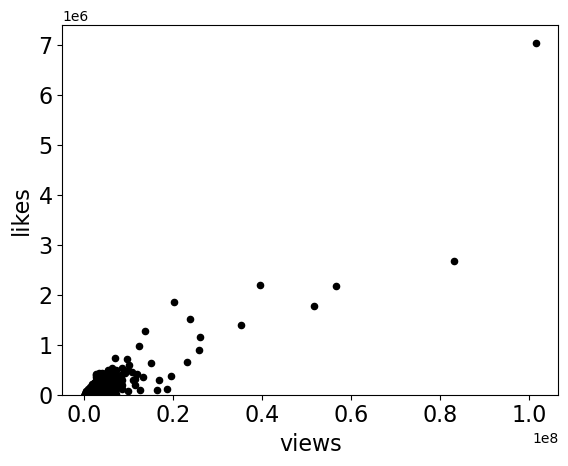

In [14]:
#Q4: Plot the correlation between the views (x-axis) and likes (y-axis) on a video.
views = []
likes = []

for vid_ids in videos_copy:
    if videos_copy[vid_ids]["ratings_enabled"] == False:
        continue
    else:
        all_views = videos_copy[vid_ids]["views"]
        views.append(all_views)
        all_likes = videos_copy[vid_ids]["likes"]
        likes.append(all_likes)
    

scatter(views, likes, xlabel="views", ylabel="likes")

In [15]:
#Q4.1 Verify your plot using verify_scatter
verify_scatter(views, likes, 4)

True

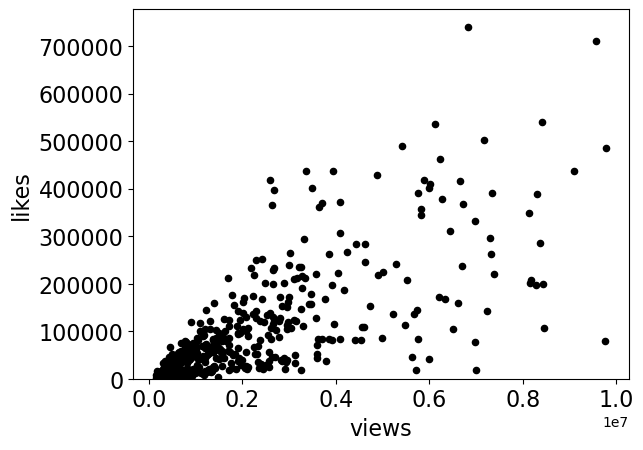

In [16]:
#Q5: Plot the correlation between the views (x-axis) and likes (y-axis) on a video with the outliers removed.
views = []
likes = []

for vid_ids in videos_copy:
    if videos_copy[vid_ids]["ratings_enabled"] == False:
        continue
    else: 
        all_views = videos_copy[vid_ids]["views"]
        if all_views > 10**7:
            continue
        views.append(all_views)
        all_likes = videos_copy[vid_ids]["likes"]
        likes.append(all_likes)

scatter(views, likes, xlabel="views", ylabel="likes")

In [17]:
#Q5.1 Verify your plot using verify_scatter
verify_scatter(views, likes, 5)

True

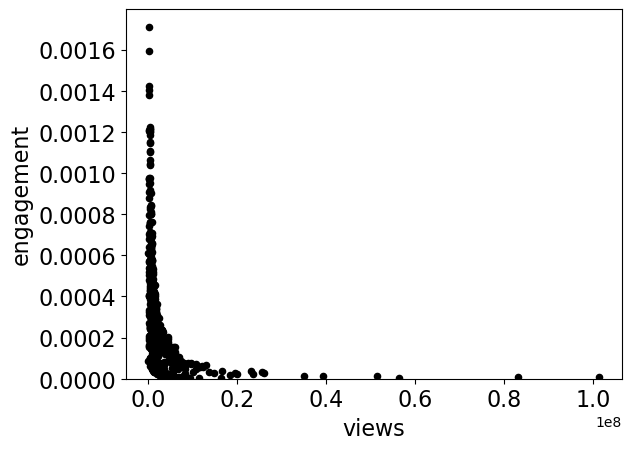

In [18]:
#Q6: Plot the correlation between the views (x-axis) and audience engagement (y-axis) on a video.
views = []
audiance_engagement = []

for vid_ids in videos_copy:
    all_views = videos_copy[vid_ids]["views"]
    views.append(all_views)
    com_view_ration = len(videos_copy[vid_ids]["comments"])/(videos_copy[vid_ids]["views"])
    audiance_engagement.append(com_view_ration)
    

scatter(views, audiance_engagement, xlabel="views", ylabel="engagement")

In [19]:
#Q6.1 Verify your plot using verify_scatter
verify_scatter(views, audiance_engagement, 6)

True

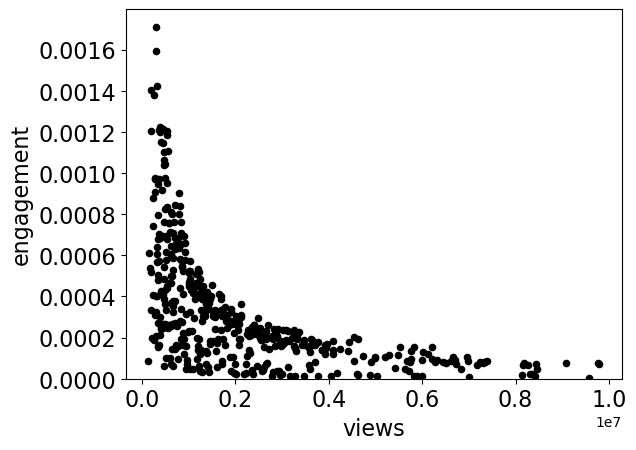

In [20]:
#Q7: Plot the correlation between the views (x-axis) and audience engagement (y-axis) on a video with the outliers removed.
views = []
audiance_engagement = []

for vid_ids in videos_copy:
    all_views = videos_copy[vid_ids]["views"]
    if all_views > 10**7:
        continue
    views.append(all_views)
    com_view_ration = len(videos_copy[vid_ids]["comments"])/(videos_copy[vid_ids]["views"])
    audiance_engagement.append(com_view_ration)
    
scatter(views, audiance_engagement, xlabel="views", ylabel="engagement")

In [21]:
#Q7.1 Verify your plot using verify_scatter
verify_scatter(views, audiance_engagement, 7)

True

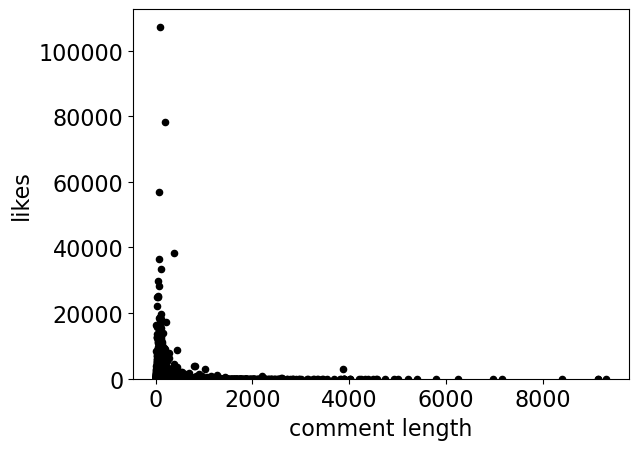

In [22]:
#Q8: Plot the correlation between the length of a comment text (x-axis) and the number of likes on the comment (y-axis).
len_of_comment = []
num_comment_likes = []

for comment_id in comments:
    num_likes = comments[comment_id].likes
    len_comment = comments[comment_id].comment_length
    len_of_comment.append(len_comment)
    num_comment_likes.append(num_likes)

scatter(len_of_comment, num_comment_likes, xlabel="comment length", ylabel="likes")


In [23]:
#Q8.1 Verify your plot using verify_scatter
verify_scatter(len_of_comment, num_comment_likes, 8)

True

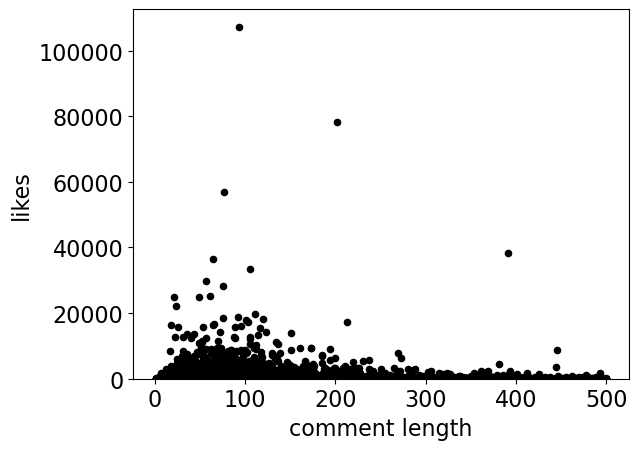

In [24]:
#Q9: Plot the correlation between the length of a comment text (x-axis) and the number of likes on the comment (y-axis) with the outliers removed.
len_of_comment = []
num_comment_likes = []

for comment_id in comments:
    num_likes = comments[comment_id].likes
    len_comment = comments[comment_id].comment_length
    if len_comment > 500:
        continue
    len_of_comment.append(len_comment)
    num_comment_likes.append(num_likes)

scatter(len_of_comment, num_comment_likes, xlabel="comment length", ylabel="likes")



In [25]:
#Q9.1 Verify your plot using verify_scatter
verify_scatter(len_of_comment, num_comment_likes, 9)

True

In [26]:
def sort_comments_by_published_time(video_title):
    comment_id_by_published_time = {}
    for video_ids in videos:
        if video_title == videos[video_ids]["title"]:
            comment_ids = videos[video_ids]["comments"]
            for comment in comments:
                if comment in comment_ids:
                    published_time = comments[comment].published_at
                    comment_id_by_published_time[published_time] = comment
    sorted_comment_dict = dict(sorted(comment_id_by_published_time.items()))
    return list(sorted_comment_dict.values())

In [27]:
assert sort_comments_by_published_time("Out of pocket tik toks 4")[0] == "UgxI96cloxd04ldEkv94AaABAg"

In [28]:
#Q10: What is the length of the first comment under the video "If I lose a boss fight, the video ends 2 (Genshin Impact)"?
first_comment = sort_comments_by_published_time("If I lose a boss fight, the video ends 2 (Genshin Impact)")[0]
comments[first_comment].comment_length    


66

In [29]:
#Q11: What is the average number of likes for the first 5 comments under the video 'Facebook, Instagram and WhatsApp down in global outage'?
facebook_video = sort_comments_by_published_time("Facebook, Instagram and WhatsApp down in global outage")[0:5]
total_likes = 0 
num = len(facebook_video)
for comment_id in facebook_video:
    like = comments[comment_id].likes
    total_likes += like
total_likes/num

478.6

In [30]:
def time_delta(start, end):
    '''takes in start and end times in "yyyy-mm-dd hh:mm:ss" format and returns the number of days (as a float) between the two times '''
    start_dt = dt.strptime(start,'%Y-%m-%d %H:%M:%S')
    end_dt = dt.strptime(end, '%Y-%m-%d %H:%M:%S')
    return (end_dt-start_dt).total_seconds()/86400

In [31]:
assert time_delta('2021-11-16 10:00:15', '2021-11-18 08:30:00') == 1.937326388888889

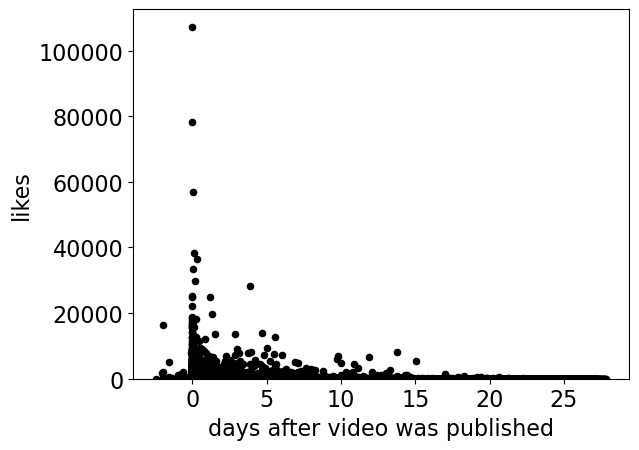

In [32]:
#Q12: Plot the correlation between when a comment is published relative to video publish time (x-axis) and the number of likes on the comment (y-axis).
time_diff = []
comm_likes = []

for video in videos:
    video_time = videos[video]["published_at"]
    comment_list = videos[video]['comments']
    
    for comment_id in comment_list:
        comment_time = comments[comment_id].published_at
        likes = comments[comment_id].likes
        time_diff.append(time_delta(video_time, comment_time)) 
        comm_likes.append(likes)
scatter(time_diff, comm_likes, xlabel = 'days after video was published', ylabel = 'likes' )


In [33]:
#Q12.1 Verify your plot using verify_scatter
verify_scatter(time_diff, comm_likes, 12)

True

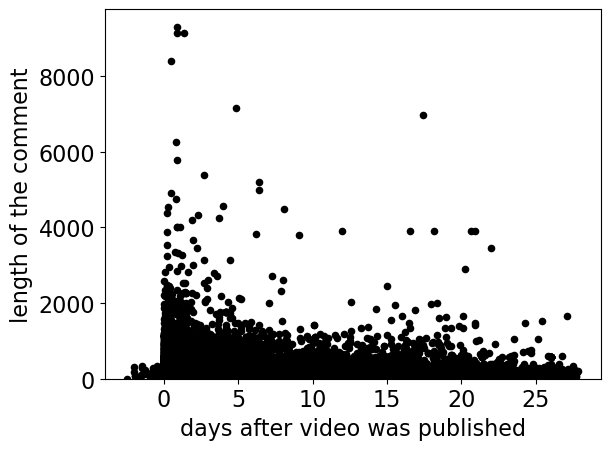

In [34]:
#Q13: Plot the correlation between when a comment is published relative to video publish time (x-axis) and the length of the comment (y-axis).
comm_length = []
time_diff = []
for video in videos:
    video_time = (videos[video]['published_at'])
    comment_list = videos[video]['comments']
    for comment_id in comment_list:
        comment_time = (comments[comment_id].published_at)
        length = comments[comment_id].comment_length
        time_diff.append(time_delta(video_time, comment_time))
        comm_length.append(length)
scatter(time_diff, comm_length, xlabel = 'days after video was published', ylabel = 'length of the comment' )


In [35]:
#Q13.1 Verify your plot using verify_scatter
verify_scatter(time_diff, comm_length, 13)

True

In [36]:
def get_all_paths_in(directory):
    file_list = []
    directory_contents = sorted(os.listdir(directory))
    for item in directory_contents:
        path_to_item = os.path.join(directory, item)
        if os.path.isfile(path_to_item) == True:
            file_list.append(path_to_item)
        else:    
            file_list.extend(get_all_paths_in(path_to_item))
    return sorted(file_list)

get_all_paths_in('broken_file')

['broken_file/english_lowercase/a_to_m/a_to_m.json',
 'broken_file/english_lowercase/rest.json',
 'broken_file/english_uppercase/A_to_E/A/A.json',
 'broken_file/english_uppercase/A_to_E/E.json',
 'broken_file/english_uppercase/A_to_E/rest/rest.json',
 'broken_file/english_uppercase/F_to_K/F_to_H.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/I/I.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/rest.json',
 'broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json',
 'broken_file/english_uppercase/R_to_W.json',
 'broken_file/english_uppercase/rest.json',
 'broken_file/non_english/korean.json',
 'broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json',
 'broken_file/non_english/russian/russian.json',
 'broken_file/number.json',
 'broken_file/special/special.json']

In [37]:
#Q14: What are the paths of the files in the special directory of the broken_file directory?
special_paths = os.path.join('broken_file', 'special')
get_all_paths_in(special_paths)

['broken_file/special/special.json']

In [38]:
#Q15: What are the paths of the files in the rest directory of the non_english directory of the broken_file directory?
non_eng_paths = os.path.join('broken_file', 'non_english')
rest_paths = os.path.join(non_eng_paths, 'rest')
get_all_paths_in(rest_paths)


['broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json']

In [39]:
#Q16: What are the paths of the files in the L_to_Q directory of the english_uppercase directory of the broken_file directory?
eng_uppercase_paths = os.path.join('broken_file', 'english_uppercase')
L_Q_paths = os.path.join(eng_uppercase_paths, 'L_to_Q')
get_all_paths_in(L_Q_paths)


['broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json']

In [40]:
#Q17: What are the paths of the files in the broken_file directory?
all_broken_paths = get_all_paths_in('broken_file')
all_broken_paths

['broken_file/english_lowercase/a_to_m/a_to_m.json',
 'broken_file/english_lowercase/rest.json',
 'broken_file/english_uppercase/A_to_E/A/A.json',
 'broken_file/english_uppercase/A_to_E/E.json',
 'broken_file/english_uppercase/A_to_E/rest/rest.json',
 'broken_file/english_uppercase/F_to_K/F_to_H.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/I/I.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/rest.json',
 'broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json',
 'broken_file/english_uppercase/R_to_W.json',
 'broken_file/english_uppercase/rest.json',
 'broken_file/non_english/korean.json',
 'broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json',
 'broken_file/non_english/russian/russian.json',
 'broken_file/number.json',
 'broken_file/special/special.json']

In [41]:
#Q18: How many channel mappings are in the files in the broken_file directory?
broken_mapping = {}
for path in all_broken_paths:
    current_path = get_mapping(path)
    for channel in current_path:
        broken_mapping[channel] = current_path[channel]
len(broken_mapping)

18519

In [42]:
broken_mapping

{'UCQkxVP87dkLxDPkeECeySLA': 'bad_ben01',
 'UCZFTugUXB0VPuDtJPFvdTRg': 'burnt toast',
 'UCePY7BTTSGXGTk5v-uh2-xw': 'bl ank',
 'UCtoCOjYg9J0JkZ8ay6EEKhQ': 'bakayaro',
 'UCy8ndHYGpnFj7wrH7gEkwug': 'bigfoot3555',
 'UCfjCfdyRhjpAvgarHcBZcMQ': 'brenda gallagher',
 'UCpiLL24nM3vnI4YK5FX6B5A': 'blaZe_bray6969',
 'UCRVX-R7voQft2M56rBIfe9Q': 'billie beck',
 'UCT35bVOHt0XvfzfRU13ZYsw': 'brianna lore-flores',
 'UCW8K9boMhdgnTYqR4X7bzUA': 'brayden McKay',
 'UC1sMoA6E7i6LUgxcPZFvSGQ': 'brisette maribelle',
 'UCVoPzbKbftj4CM19bRy68yg': 'britney padarath',
 'UCy0wn8d-fS2qZvcr3CELWmA': 'black sheep hebrew',
 'UCIz6sbdbvy-y1kvmR5poA3g': 'borisxbg',
 'UCAh0mlMH-oCMJKOHYsg4HJg': 'braija',
 'UCSC_VIKb0XrmmaCcxmtiMqQ': 'britt',
 'UCGPmTb78fzEHhHr_fVGpSIQ': 'bryan del mundo',
 'UC0XirRZ-dJn9VuHFx9_G8uw': 'biskuit',
 'UCnqrdbsd7S8d4eqeLE2Ddog': 'blue;',
 'UCZP8_XuSMIMXZUaN8cXmPtA': 'bkupniewski',
 'UCXVqzloH9P-5oO99ZDBGOQw': 'blue_is_not_sad',
 'UCp7sSCpFCe6Su6to8d97FVw': 'bangtans.army♡♡',
 'UCB-h-m4DptFzHl

In [43]:
#Q19: What is the name of the channel with the channel ID UCwtzSiUayocxaOHLnHe90Hw?
broken_mapping['UCwtzSiUayocxaOHLnHe90Hw']

'Like it Matters'

In [44]:
#Q20: What are the names of the top 5 channels from the broken_file with the most likes on their comments?
ids_likes = {}
final_dict = {}
for comment in comments:
    authorID = comments[comment].author_id
    likes = comments[comment].likes
    if authorID not in ids_likes:
        ids_likes[authorID] = 0
    ids_likes[authorID] += likes
for channels in ids_likes:
    if channels in broken_mapping: 
        final_dict[channels] = ids_likes[channels]
sorted_list = sorted(final_dict, key = lambda x: final_dict[x], reverse = True)
sorted_list[0:5]

list_names = []
for channel_id in sorted_list[0:5]:
    list_names.append(broken_mapping[channel_id])
list_names

['ChippyGaming',
 'Odin J',
 'A comely black woman',
 'BadBoyHalo',
 'Nakatomino Calamari ']